<a href="https://colab.research.google.com/github/ceyxasm/machine_learning_implementations/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from functools import partial

## Filters and feature maps

In [4]:
from sklearn.datasets import load_sample_image
# Load sample images

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# Create 2 filters

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")


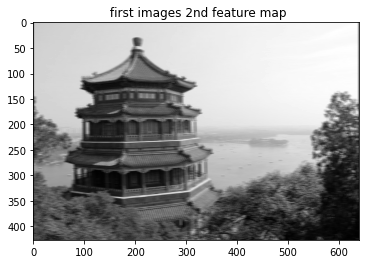

In [ ]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.title(" first images 2nd feature map")
plt.show()

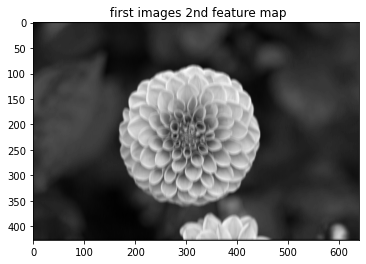

In [ ]:
plt.imshow(outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st feature map
plt.title(" first images 2nd feature map")
plt.show()

## Padding

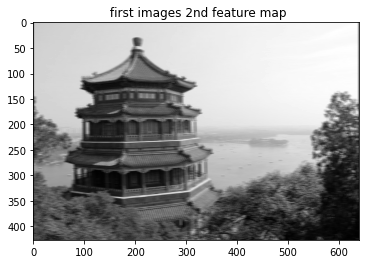

In [ ]:
output = tf.nn.max_pool(images,
        ksize=(1, 1, 1, 3),  ## a depth wise pooling procedure
        strides=(1, 1, 1, 3),
          padding="VALID")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.title(" first images 2nd feature map")
plt.show()

A common mistake is to use convolution kernels that are too large.
For example, instead of using a convolutional layer with a 5 × 5
kernel, it is generally preferable to stack two layers with 3 × 3 ker‐
nels: it will use less parameters and require less computations, and
it will usually perform better. One exception to this recommenda‐
tion is for the first convolutional layer: it can typically have a large
kernel (e.g., 5 × 5), usually with stride of 2 or more: this will reduce
the spatial dimension of the image without losing too much infor‐
mation, and since the input image only has 3 channels in general, it
will not be too costly.

## CNN Model for 10 class- classification


In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=128),
DefaultConv2D(filters=128),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=256),
DefaultConv2D(filters=256),
keras.layers.MaxPooling2D(pool_size=2),
keras.layers.Flatten(),
keras.layers.Dense(units=128, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=64, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=10, activation='softmax'),
])

## ResNet 34 (scratch)

In [2]:
DefaultConvo2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False) # Residual Layer

class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.activation= keras.activations.get(activation)
    self.main_layers= [
                       DefaultConvo2D( filters, strides= strides),
                       keras.layers.BatchNormalization(),
                       self.activation,
                       DefaultConvo2D( filters),
                       keras.layers.BatchNormalization()
    ]
    self.skip_layers= []
    if strides>1:
      self.skip_layers= [
                         DefaultConvo2D(filters, kernel_size=1, strides= strides),
                         keras.layers.BatchNormalization()
      ]

  def call(self, inputs):
    Z= inputs
    for layer in self.main_layers:
      Z= layer(Z)
    skip_Z= inputs
    for layer in self.skip_layers:
      skip_Z= layer(skip_Z)
    
    return self.activation( Z+ skip_Z)


In [3]:
'''we can treat each residual unit as a single layer now
that we have the ResidualUnit class'''

model = keras.models.Sequential()
model.add(DefaultConvo2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add( ResidualUnit(  filters, strides=strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

## Pretrained Models In Keras // ResNet 50

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights="imagenet")
#resnet 50 takes images of size 224*224
images_resized = tf.image.resize(images, [224, 224])

102981632/102967424 [==============================] - 1s 0us/step


The tf.image.resize() will not preserve the aspect ratio. If this is
a problem, you can try cropping the images to the appropriate
aspect ratio before resizing. Both operations can be done in one
shot with tf.image.crop_and_resize().

In [12]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized * 255)
##each model is provided with inbuilt preprocess function; it takes input of images as pixel value from 0-225

Y_proba = model.predict(inputs)

top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print("Image #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
  print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
 n02825657 - bell_cote    82.35%
 n03877845 - palace       6.75%
 n03781244 - monastery    4.19%

Image #1
 n03530642 - honeycomb    49.83%
 n13040303 - stinkhorn    33.96%
 n02206856 - bee          4.35%



## Pretrained models for transfer learning // Xception

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
test_split, valid_split, train_split = ['train[:10%]','train[10%:25%]','train[25%:]']

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

In [3]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = tf.keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [6]:
batch_size = 32
train_set = train_set.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [7]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                    include_top=False) #excludes the top global pool and dense layer
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
for layer in base_model.layers:
  layer.trainable = False

optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                                metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


86/86 [==============================] - 31s 151ms/step - loss: 1.1677 - accuracy: 0.8114 - val_loss: 0.8517 - val_accuracy: 0.8621
Epoch 2/5
86/86 [==============================] - 13s 147ms/step - loss: 0.4375 - accuracy: 0.9106 - val_loss: 1.0053 - val_accuracy: 0.8603
Epoch 3/5
86/86 [==============================] - 13s 146ms/step - loss: 0.2186 - accuracy: 0.9462 - val_loss: 0.7078 - val_accuracy: 0.8676
Epoch 4/5
86/86 [==============================] - 13s 147ms/step - loss: 0.1079 - accuracy: 0.9604 - val_loss: 0.7012 - val_accuracy: 0.8621
Epoch 5/5
86/86 [==============================] - 13s 154ms/step - loss: 0.0696 - accuracy: 0.9753 - val_loss: 0.7011 - val_accuracy: 0.8695


In [11]:
for layer in base_model.layers:
  layer.trainable = True

optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                                metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


86/86 [==============================] - 60s 607ms/step - loss: 0.3152 - accuracy: 0.8964 - val_loss: 0.4628 - val_accuracy: 0.8934
Epoch 2/5
86/86 [==============================] - 52s 611ms/step - loss: 0.0880 - accuracy: 0.9764 - val_loss: 0.4760 - val_accuracy: 0.8915
Epoch 3/5
86/86 [==============================] - 53s 622ms/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.3590 - val_accuracy: 0.9228
Epoch 4/5
86/86 [==============================] - 53s 621ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.3929 - val_accuracy: 0.9173
Epoch 5/5
86/86 [==============================] - 53s 620ms/step - loss: 0.0165 - accuracy: 0.9938 - val_loss: 0.3097 - val_accuracy: 0.9283
